In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.api as sm
import re

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("tab10")

In [2]:
# Create a connection to the SQLite database
conn = sqlite3.connect('data/plots.db')

# Define the SQL query to get comprehensive dataset for analysis
all_data_query = """
SELECT 
    p.doi,
    p.figure_number,
    s.sandstone_name,
    dp.p_mpa,
    dp.q_mpa
FROM data_points dp
JOIN sandstones s ON dp.sandstone_id = s.id
JOIN plots p ON s.plot_id = p.id
ORDER BY p.doi, s.sandstone_name, dp.p_mpa
"""

In [3]:
# Convert the SQL query result into a DataFrame
df_all_data = pd.read_sql_query(all_data_query, conn)

# Display the DataFrame 
df_all_data

,doi,figure_number,sandstone_name,p_mpa,q_mpa
0,10.1016/j.jsg.2012.07.010,5b,"Adamswiller (22.6%), Wong et al. (1997)",32.558140,74.004684
1,10.1016/j.jsg.2012.07.010,5b,"Adamswiller (22.6%), Wong et al. (1997)",56.395349,102.107728
2,10.1016/j.jsg.2012.07.010,5b,"Adamswiller (22.6%), Wong et al. (1997)",80.813953,113.817330
3,10.1016/j.jsg.2012.07.010,5a,"Bentheim (22.8%), Baud et al. (2006)",51.162791,103.255814
4,10.1016/j.jsg.2012.07.010,5a,"Bentheim (22.8%), Baud et al. (2006)",53.488372,112.558140
...,...,...,...,...,...
157,10.1016/j.jsg.2012.08.014,8,Serpentinite (20%),237.942122,287.015945
158,10.1016/j.jsg.2012.08.014,8,Serpentinite (20%),246.945338,277.904328
159,10.1016/j.jsg.2012.08.014,8,Serpentinite (20%),271.382637,305.239180
160,10.1016/j.jsg.2012.08.014,8,Serpentinite (20%),285.530547,300.683371


In [4]:
# Filter for Rutter and Glover Figure 8 data
rut_glov_fig8 = df_all_data[df_all_data['figure_number'] == '8']

# Filter for friction data
friction_data = rut_glov_fig8[rut_glov_fig8['sandstone_name'] == 'Porous sandstone friction data']

# Remove Serpentinite data
rut_glov_fig8 = rut_glov_fig8[(rut_glov_fig8['sandstone_name'] != 'Serpentinite (20%)') & (rut_glov_fig8['sandstone_name'] != 'Porous sandstone friction data')]

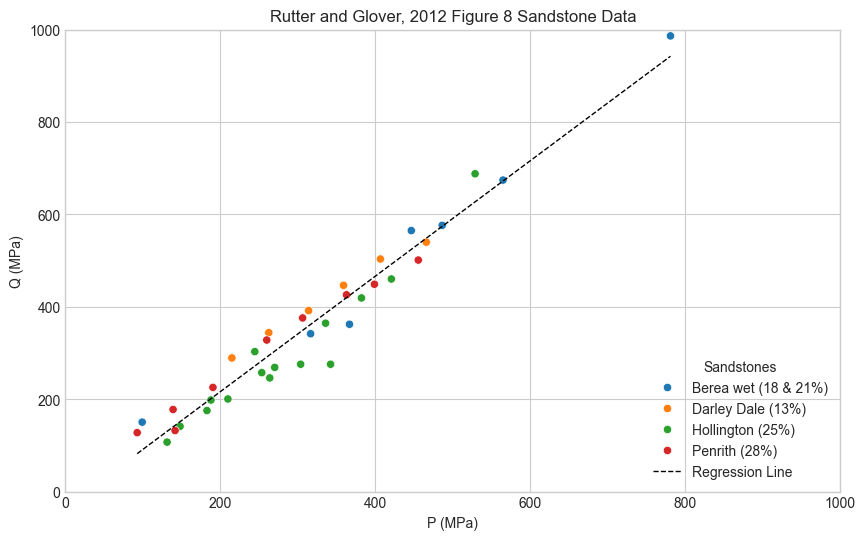

In [5]:
# Visualise the sandstone data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rut_glov_fig8, x='p_mpa', y='q_mpa', hue='sandstone_name')
sns.regplot(data=rut_glov_fig8, x='p_mpa', y='q_mpa', scatter=False, 
            color='black', ci=None, label='Regression Line', 
            line_kws={'linewidth': 1.0, 'linestyle': '--'})
plt.xlabel('P (MPa)', fontsize=10)
plt.ylabel('Q (MPa)', fontsize=10)
plt.xlim(0,1000)
plt.ylim(0,1000)    
plt.title('Rutter and Glover, 2012 Figure 8 Sandstone Data')
plt.legend(loc='lower right', title='Sandstones')
plt.savefig("stats_plots/Rutter_Glover_2012_Fig8.png", dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# OLS Regression
X = rut_glov_fig8['p_mpa']
y = rut_glov_fig8['q_mpa']
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X).fit()
print(f"OLS Regression Results for Rutter and Glover Figure 8 Sandstone Data \n")
print(model.summary())

OLS Regression Results for Rutter and Glover Figure 8 Sandstone Data 

                            OLS Regression Results                            
Dep. Variable:                  q_mpa   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     700.3
Date:                Mon, 14 Jul 2025   Prob (F-statistic):           9.88e-25
Time:                        15:32:35   Log-Likelihood:                -189.07
No. Observations:                  37   AIC:                             382.1
Df Residuals:                      35   BIC:                             385.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

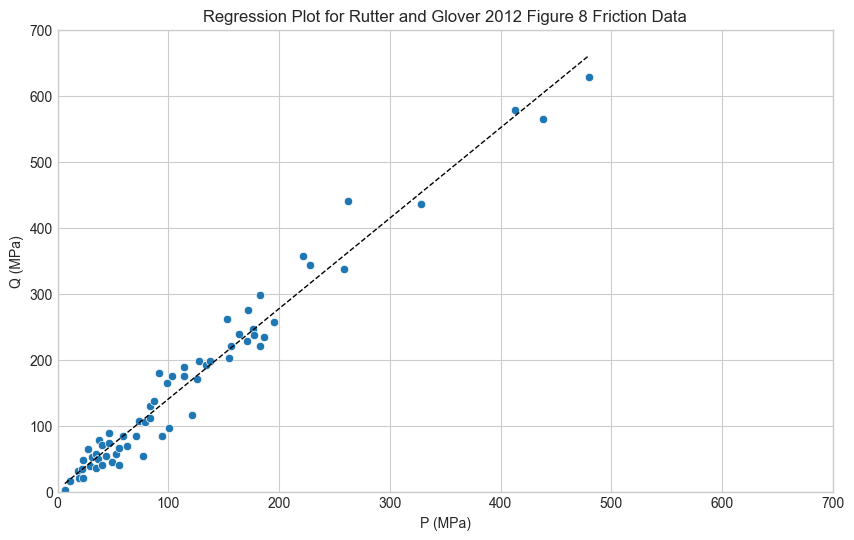

In [7]:
# Create a regression plot for the friction data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=friction_data, x='p_mpa', y='q_mpa')
sns.regplot(data=friction_data, x='p_mpa', y='q_mpa', scatter=False, 
            color='black', ci=None, label='Regression Line', 
            line_kws={'linewidth': 1.0, 'linestyle': '--'})
plt.xlim(0, 700)
plt.ylim(0, 700)
plt.xlabel('P (MPa)', fontsize=10)
plt.ylabel('Q (MPa)', fontsize=10)
plt.title('Regression Plot for Rutter and Glover 2012 Figure 8 Friction Data')
plt.savefig("stats_plots/Rutter_Glover_2012_Fig8_FrictionData.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# OLS for friction data
friction_X = friction_data['p_mpa']
friction_y = friction_data['q_mpa']
friction_X = sm.add_constant(friction_X)  # Adds a constant term to the predictor
friction_model = sm.OLS(friction_y, friction_X).fit()
print(f"OLS Regression Results for Rutter and Glover 2012 Friction Data \n")
print(friction_model.summary())

OLS Regression Results for Rutter and Glover 2012 Friction Data 

                            OLS Regression Results                            
Dep. Variable:                  q_mpa   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1750.
Date:                Mon, 14 Jul 2025   Prob (F-statistic):           3.76e-47
Time:                        15:32:36   Log-Likelihood:                -299.42
No. Observations:                  64   AIC:                             602.8
Df Residuals:                      62   BIC:                             607.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

## Include Wong & Baud, 2012. Figures 5a,b and 6a,b (Limestones)

In [9]:
new_df = df_all_data[(df_all_data['sandstone_name'] != 'Serpentinite (20%)') & (df_all_data['sandstone_name'] != 'Porous sandstone friction data')]
limestones = new_df[(new_df['figure_number'] == '6a') | (new_df['figure_number'] == '6b')]

# Remove limestones from the main dataset
new_df = new_df[~new_df['sandstone_name'].isin(limestones['sandstone_name'])]
new_df.figure_number.unique()

array(['5b', '5a', '8'], dtype=object)

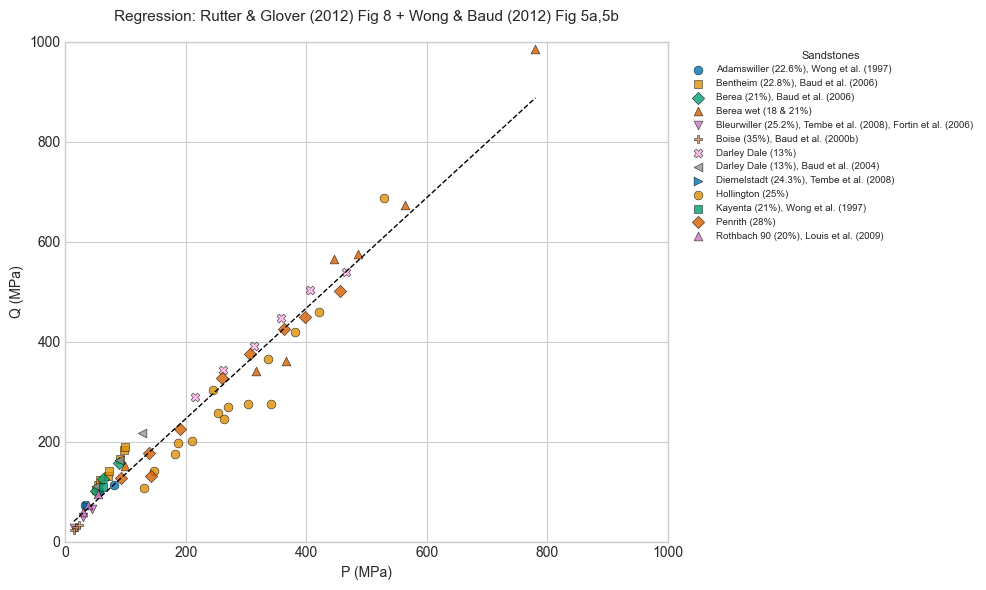

In [10]:
# Create a regression plot for new data including Wong and Baud, 2012 data

# Sort the sandstone names for consistent ordering
sandstones = sorted(new_df['sandstone_name'].unique())
n_groups = len(sandstones)

# Pairing colors and markers
colors = sns.color_palette("colorblind", n_colors=min(n_groups, 8))
markers = ['o', 's', 'D', '^', 'v', 'P', 'X', '<', '>'] 

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each group separately
for i, name in enumerate(sandstones):
    group = new_df[new_df['sandstone_name'] == name]
    ax.scatter(
        group['p_mpa'], group['q_mpa'],
        label=name,
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        edgecolor='black',
        linewidth=0.4,
        s=40,
        alpha=0.8
    )

# Regression line
sns.regplot(
    data=new_df, x='p_mpa', y='q_mpa',
    scatter=False, ci=None,
    line_kws={'color': 'black', 'linewidth': 1.0, 'linestyle': '--'},
    ax=ax
)

ax.set_xlabel('P (MPa)', fontsize=10)
ax.set_ylabel('Q (MPa)', fontsize=10)
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)

# Legend
ax.legend(
    bbox_to_anchor=(1.02, 1), loc='upper left',
    fontsize=7, title='Sandstones',
    title_fontsize=8, frameon=False, ncol=1
)

plt.title('Regression: Rutter & Glover (2012) Fig 8 + Wong & Baud (2012) Fig 5a,5b', fontsize=11, pad=15)
plt.tight_layout()
plt.savefig("stats_plots/RutterGlover, 2012_Fig8 & WongBaud_2012 Fig5a,b.png", dpi=300, bbox_inches='tight')
plt.show()


In [11]:
# OLS Regression for new_df
X_new = new_df['p_mpa']
y_new = new_df['q_mpa']
X_new = sm.add_constant(X_new)  # Adds a constant term to the predictor
model_new = sm.OLS(y_new, X_new).fit()
print(model_new.summary())


                            OLS Regression Results                            
Dep. Variable:                  q_mpa   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1368.
Date:                Mon, 14 Jul 2025   Prob (F-statistic):           1.92e-44
Time:                        15:32:37   Log-Likelihood:                -331.84
No. Observations:                  65   AIC:                             667.7
Df Residuals:                      63   BIC:                             672.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.9988      7.888      3.169      0.0

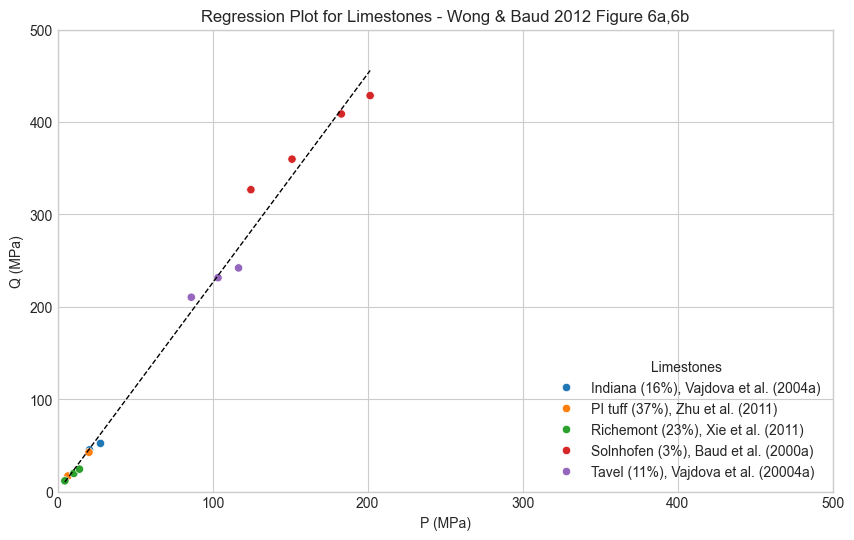

In [12]:
# Create a regression plot for limestones
plt.figure(figsize=(10, 6))
sns.scatterplot(data=limestones, x='p_mpa', y='q_mpa', hue='sandstone_name')
sns.regplot(data=limestones, x='p_mpa', y='q_mpa', scatter=False, 
            ci=None, line_kws={'color': 'black', 'linewidth': 1.0, 'linestyle': '--'})
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.xlabel('P (MPa)')
plt.ylabel('Q (MPa)')
plt.legend(loc='lower right', title='Limestones')
plt.title('Regression Plot for Limestones - Wong & Baud 2012 Figure 6a,6b')
plt.savefig("stats_plots/Limestones WongBaud_2012 Fig6a,b.png", dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# OLS Regression for limestones
X_limestone = limestones['p_mpa']
y_limestone = limestones['q_mpa']
X_limestone = sm.add_constant(X_limestone)  # Adds a constant term to the
model_limestone = sm.OLS(y_limestone, X_limestone).fit()
print(f" Wong & Baud Fig 6a,b \n{model_limestone.summary()}")

 Wong & Baud Fig 6a,b 
                            OLS Regression Results                            
Dep. Variable:                  q_mpa   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     983.5
Date:                Mon, 14 Jul 2025   Prob (F-statistic):           6.96e-13
Time:                        15:32:38   Log-Likelihood:                -59.475
No. Observations:                  14   AIC:                             122.9
Df Residuals:                      12   BIC:                             124.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1381      7.

c:\Users\qmxj311\AppData\Local\anaconda3\envs\env\lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


## Extract Porosity of the Sandstones

In [14]:
# Extract Porosity of the Sandstones
def extract_porosity(s):
    """
    Extracts the porosity percentage from a string formatted like "(x%)"
    """
    matches = re.findall(r"\(([^)]+%)\)")
    if matches:
        return matches[0]
    else:
        return None

In [15]:
# Extract Porosity of the Sandstones
def extract_porosity(s):
    matches = re.findall(r"\(([^)]+%)\)", s)
    if matches:
        return matches[0]
    else:
        return None
    
# Add a new column for porosity

new_df['porosity'] = new_df['sandstone_name'].apply(extract_porosity)

# Choose porosity as 18 for Berea wet
new_df_18 = new_df.copy()
new_df_18.loc[new_df_18['porosity'] == '18 & 21%', 'porosity'] = '18%'

# Choose porosity as 21 for Berea wet
new_df_21 = new_df.copy()
new_df_21.loc[new_df_21['porosity'] == '18 & 21%', 'porosity'] = '21%'

# Remove the percentage sign and convert to float
new_df_18['porosity'] = new_df_18['porosity'].str.replace('%', '').astype(float)
new_df_21['porosity'] = new_df_21['porosity'].str.replace('%', '').astype(float)

In [16]:
# Range of porosity values
print("Range of porosity values using Berea wet 18:")
print(new_df_18['porosity'].describe().round(2))

print("\nRange of porosity values using Berea wet 21:")
print(new_df_21['porosity'].describe().round(2))

Range of porosity values using Berea wet 18:
count    65.00
mean     22.60
std       5.36
min      13.00
25%      20.00
50%      22.80
75%      25.00
max      35.00
Name: porosity, dtype: float64

Range of porosity values using Berea wet 21:
count    65.00
mean     22.92
std       5.16
min      13.00
25%      21.00
50%      22.80
75%      25.00
max      35.00
Name: porosity, dtype: float64


# Different Porosoity Plots

In [17]:
# Split data based on median porosity

median_porosity = new_df_18['porosity'].median()

# Dataframes for porosity below and above median
below_median = new_df_18[new_df_18['porosity'] < median_porosity]
above_median = new_df_18[new_df_18['porosity'] >= median_porosity]

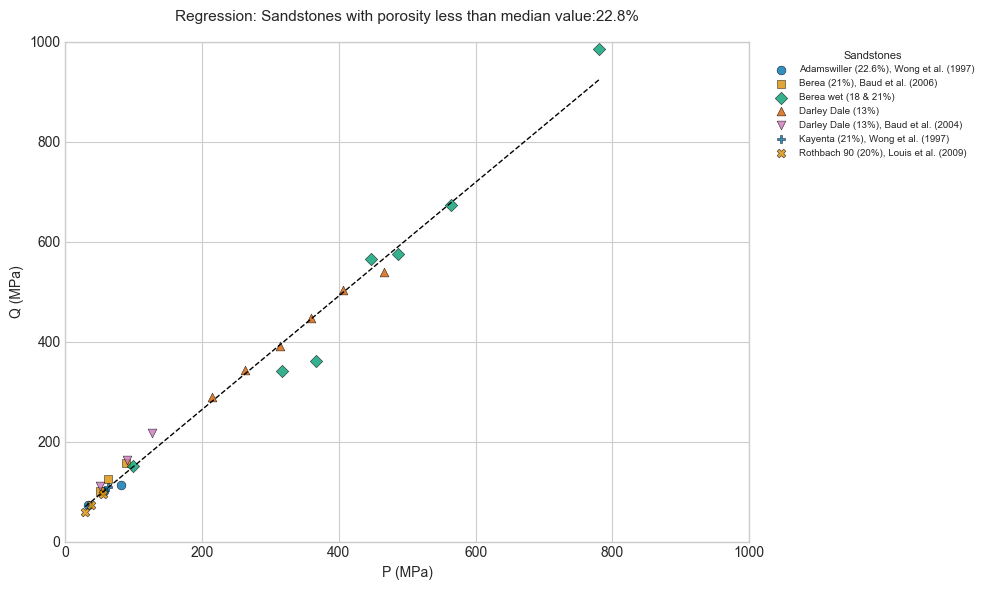

In [19]:
# Sort the sandstone names for consistent ordering
sandstones_below = sorted(below_median['sandstone_name'].unique())
n_groups = len(sandstones_below)

# Pairing colors and markers
colors = sns.color_palette("colorblind", n_colors=min(n_groups, 5))
markers = ['o', 's', 'D', '^', 'v', 'P', 'X', '<', '>'] 

fig, ax = plt.subplots(figsize=(10, 6))
for i, name in enumerate(sandstones_below):
    group = below_median[below_median['sandstone_name'] == name]
    ax.scatter(
        group['p_mpa'], group['q_mpa'],
        label=name,
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        edgecolor='black',
        linewidth=0.4,
        s=40,
        alpha=0.8
    )
sns.regplot(
    data=below_median, x='p_mpa', y='q_mpa',
    scatter=False, ci=None,
    line_kws={'color': 'black', 'linewidth': 1.0, 'linestyle': '--'},
    ax=ax
)
ax.set_xlabel('P (MPa)', fontsize=10)
ax.set_ylabel('Q (MPa)', fontsize=10)
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)

# Legend
ax.legend(
    bbox_to_anchor=(1.02, 1), loc='upper left',
    fontsize=7, title='Sandstones',
    title_fontsize=8, frameon=False, ncol=1
)

plt.title(f'Regression: Sandstones with porosity less than median value:{median_porosity}%', fontsize=11, pad=15)
plt.tight_layout()
plt.savefig("stats_plots/porosity less than 22.8.png", dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# OLS Regression for below median porosity
X_below = below_median['p_mpa']
y_below = below_median['q_mpa']
X_below = sm.add_constant(X_below)  # Adds a constant term to the predictor
model_below = sm.OLS(y_below, X_below).fit()
print(f"Regression Stats for Sandstones less than 22.8: \n{model_below.summary()}")

Regression Stats for Sandstones less than 22.8: 
                            OLS Regression Results                            
Dep. Variable:                  q_mpa   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1631.
Date:                Mon, 14 Jul 2025   Prob (F-statistic):           1.40e-23
Time:                        15:33:25   Log-Likelihood:                -123.29
No. Observations:                  26   AIC:                             250.6
Df Residuals:                      24   BIC:                             253.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

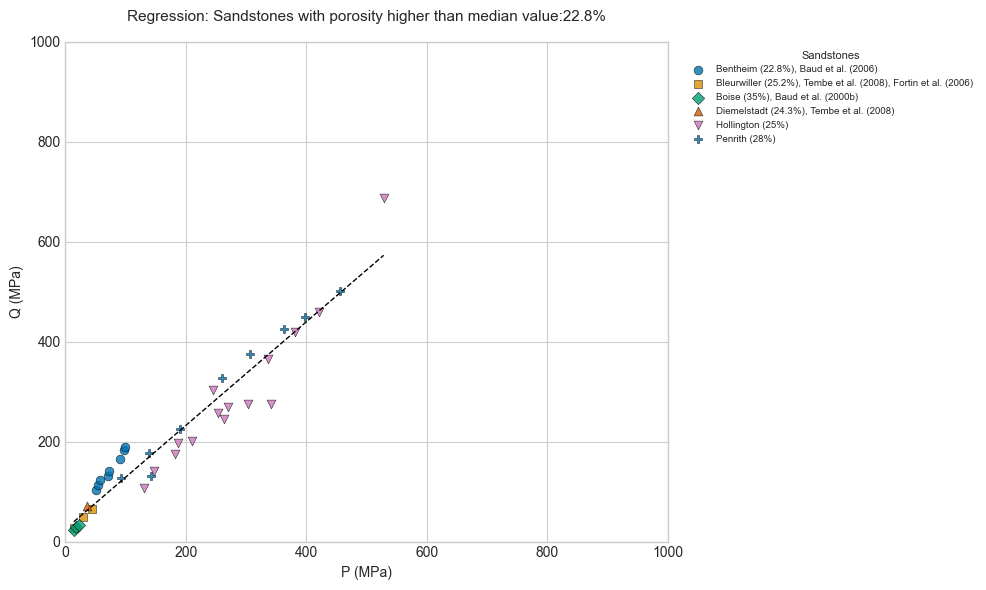

In [21]:
# Sort the sandstone names for consistent ordering
sandstones_above = sorted(above_median['sandstone_name'].unique())
n_groups = len(sandstones_above)

# Pairing colors and markers
colors = sns.color_palette("colorblind", n_colors=min(n_groups, 5))
markers = ['o', 's', 'D', '^', 'v', 'P', 'X', '<', '>'] 

fig, ax = plt.subplots(figsize=(10, 6))
for i, name in enumerate(sandstones_above):
    group = above_median[above_median['sandstone_name'] == name]
    ax.scatter(
        group['p_mpa'], group['q_mpa'],
        label=name,
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        edgecolor='black',
        linewidth=0.4,
        s=40,
        alpha=0.8
    )
sns.regplot(
    data=above_median, x='p_mpa', y='q_mpa',
    scatter=False, ci=None,
    line_kws={'color': 'black', 'linewidth': 1.0, 'linestyle': '--'},
    ax=ax
)
ax.set_xlabel('P (MPa)', fontsize=10)
ax.set_ylabel('Q (MPa)', fontsize=10)
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)

# Legend
ax.legend(
    bbox_to_anchor=(1.02, 1), loc='upper left',
    fontsize=7, title='Sandstones',
    title_fontsize=8, frameon=False, ncol=1
)

plt.title(f'Regression: Sandstones with porosity higher than median value:{median_porosity}%', fontsize=11, pad=15)
plt.tight_layout()
plt.savefig("stats_plots/porosity more than 22.8.png", dpi=300, bbox_inches='tight')
plt.show()



In [22]:
# OLS Regression for above median porosity
X_above = above_median['p_mpa']
y_above = above_median['q_mpa']
X_above = sm.add_constant(X_above)  # Adds a constant term to the predictor
model_above = sm.OLS(y_above, X_above).fit()
print(f"Regression Stats for Sandstones higher than 22.8: \n{model_above.summary()}")

Regression Stats for Sandstones higher than 22.8: 
                            OLS Regression Results                            
Dep. Variable:                  q_mpa   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     482.2
Date:                Mon, 14 Jul 2025   Prob (F-statistic):           8.10e-23
Time:                        15:33:26   Log-Likelihood:                -199.35
No. Observations:                  39   AIC:                             402.7
Df Residuals:                      37   BIC:                             406.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c